## Import the desired modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error as MSE

from  keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
from keras import layers
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping
from keras.models import load_model


# Set random seed
np.random.seed(0)

C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [3]:
from  keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K
from keras import layers
from keras.initializers import Zeros

In [4]:
# Set figure size for all matplotlib figures
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5

In [5]:
# Use the script generated to scrap the rate data
from getdata_01 import *
rate_data = get_data()

In [6]:
rate_data.head()

,Rate
Day,
2018-02-25,64.7647
2018-02-26,64.7880
2018-02-27,64.9217
2018-02-28,65.2619
2018-03-01,65.1559


In [7]:
rate_data.tail()

,Rate
Day,
2018-08-19,69.8295
2018-08-20,69.7633
2018-08-21,69.8126
2018-08-22,69.7988
2018-08-23,70.2874


In [8]:
rate_data.describe()

,Rate
count,180.000000
mean,67.199299
std,1.603171
min,64.706800
25%,65.206175
50%,67.513700
75%,68.515475
max,70.287400


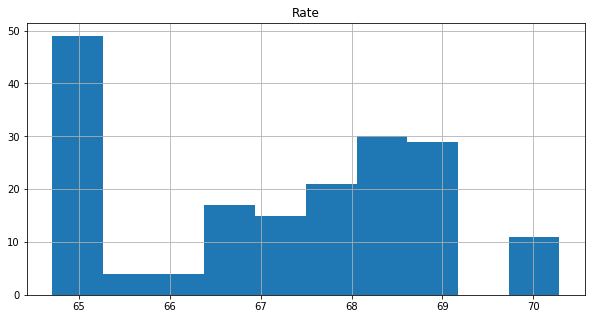

In [9]:
rate_data.hist()
plt.show()

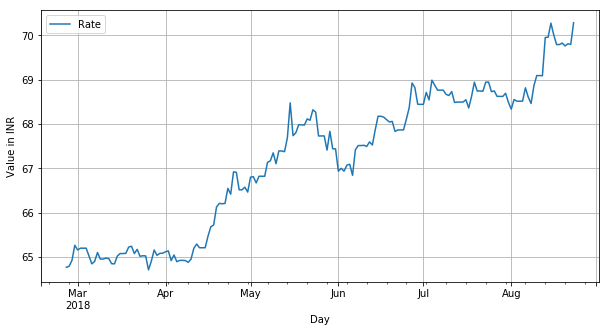

In [10]:
plt.rcParams["figure.figsize"] = fig_size
rate_data.plot()
plt.ylabel('Value in INR')
plt.grid()

## Stationarity analysis

Determine stationarity <br>
Dickey-Fuller test for stationarity

In [11]:
df_test = adfuller(rate_data['Rate'], autolag='AIC')
result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test[4].items():
    result['Critical Value (%s)'%key] = value
print (result)

Test Statistic                  -0.341526
p-value                          0.919414
#Lags Used                       1.000000
Number of Observations Used    178.000000
Critical Value (1%)             -3.467632
Critical Value (5%)             -2.877918
Critical Value (10%)            -2.575501
dtype: float64


### Introducing stationarity

### 1. Difference between data and moving average

Plot rolling mean (Moving Average)

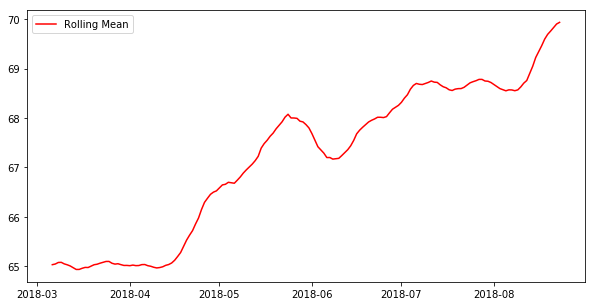

In [12]:
rolling_mean = pd.Series.rolling(rate_data['Rate'],window=10,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
#rate_data.plot()
rmean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.show()

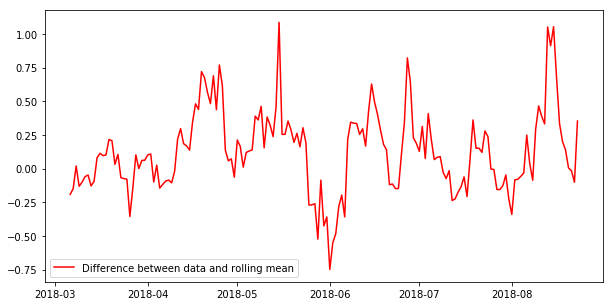

In [13]:
rolling_mean_diff=rate_data['Rate']-rolling_mean
#plt.rcParams["figure.figsize"] = fig_size
plt.plot(rolling_mean_diff, color='red',label='Difference between data and rolling mean')
plt.legend(loc='best')
plt.show()
rolling_mean_diff.dropna(inplace=True)

In [14]:
df_rmean_diff = adfuller(rolling_mean_diff, autolag='AIC')
result_rmean_diff = pd.Series(df_rmean_diff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_rmean_diff[4].items():
    result_rmean_diff['Critical Value (%s)'%key] = value
print (result_rmean_diff)

Test Statistic                  -4.651251
p-value                          0.000104
#Lags Used                       0.000000
Number of Observations Used    170.000000
Critical Value (1%)             -3.469413
Critical Value (5%)             -2.878696
Critical Value (10%)            -2.575917
dtype: float64


### 2. Moving average of log(data)

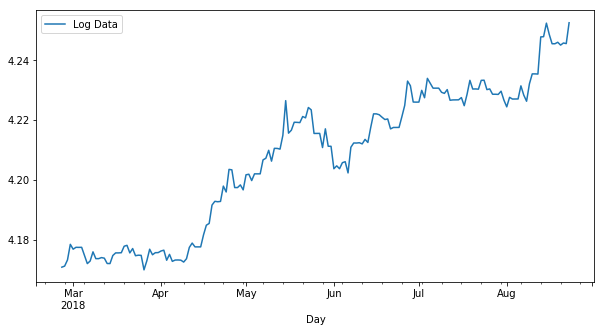

In [15]:
rate_data_log=np.log(rate_data['Rate'])
plt.rcParams["figure.figsize"] = fig_size
rate_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.show()

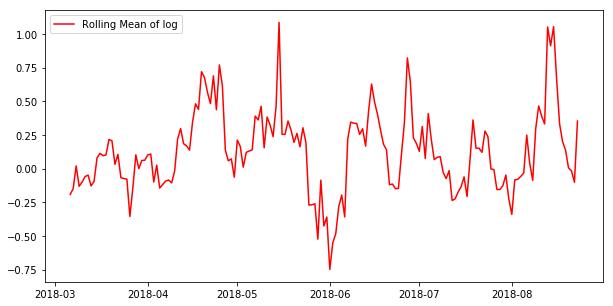

In [16]:
log_rolling_mean=pd.Series.rolling(rate_data_log,window=10,center=False).mean()
plt.rcParams["figure.figsize"] = fig_size
log_rolmean_diff=rate_data_log-log_rolling_mean
log_rmean_diff= plt.plot(rolling_mean_diff, color='red', label='Rolling Mean of log')
plt.legend(loc='best')
plt.show()
log_rolmean_diff.dropna(inplace=True)

In [17]:
df_test_log = adfuller(log_rolmean_diff, autolag='AIC')
result_log = pd.Series(df_test_log[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_log[4].items():
    result_log['Critical Value (%s)'%key] = value
print (result_log)

Test Statistic                  -4.643230
p-value                          0.000107
#Lags Used                       0.000000
Number of Observations Used    170.000000
Critical Value (1%)             -3.469413
Critical Value (5%)             -2.878696
Critical Value (10%)            -2.575917
dtype: float64


### 3. Exponentially Weighted Moving Average of Log

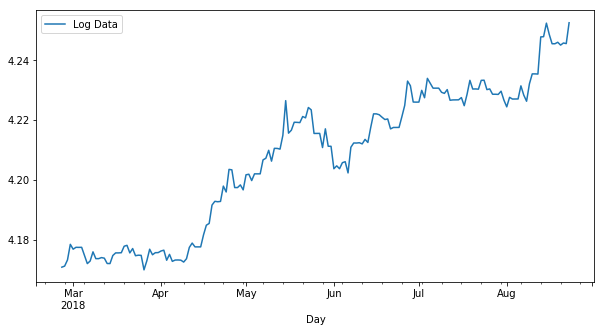

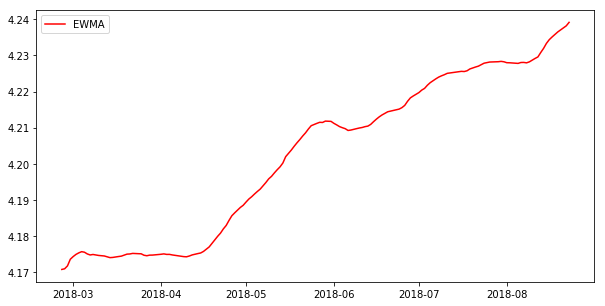

In [18]:
ewma_data=pd.Series.ewm(rate_data_log,halflife=10,min_periods=0,adjust=True,ignore_na=False).mean()
plt.rcParams["figure.figsize"] = fig_size
rate_data_log.plot(label='Log Data')
plt.legend(loc='best')
plt.show()
plt.plot(ewma_data, color='red',label='EWMA')
plt.legend()
plt.legend(loc='best')
plt.show()

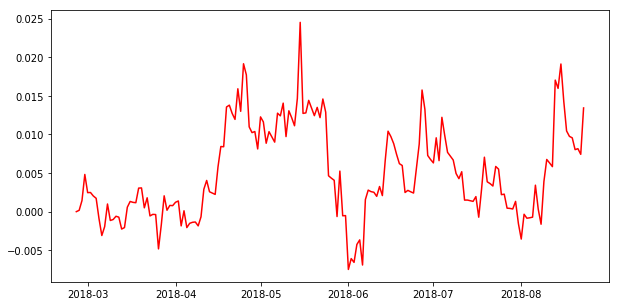

In [19]:
ewma_diff=rate_data_log-ewma_data
plt.rcParams["figure.figsize"] = fig_size
plt.plot(ewma_diff, color='red')

In [20]:
df_test_ewma = adfuller(ewma_diff, autolag='AIC')
result_ewma = pd.Series(df_test_ewma[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_ewma[4].items():
    result_ewma['Critical Value (%s)'%key] = value
print (result_ewma)

Test Statistic                  -2.831625
p-value                          0.053896
#Lags Used                       1.000000
Number of Observations Used    178.000000
Critical Value (1%)             -3.467632
Critical Value (5%)             -2.877918
Critical Value (10%)            -2.575501
dtype: float64


### 4. First order differencing

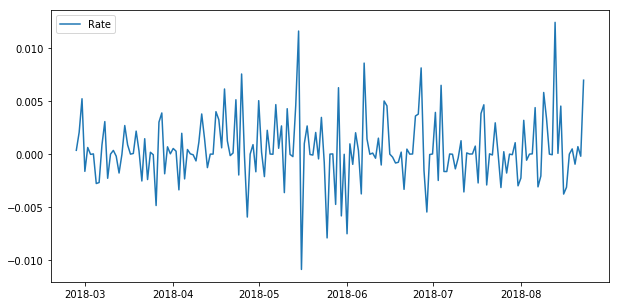

In [21]:
rate_log_diff = rate_data_log - rate_data_log.shift()
rate_log_diff.dropna(inplace=True)
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_log_diff)
plt.legend('Log Data')
plt.legend(loc='best')
plt.show()

In [22]:
df_test_logdiff = adfuller(rate_log_diff, autolag='AIC')
result_logdiff = pd.Series(df_test_logdiff[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_logdiff[4].items():
    result_logdiff['Critical Value (%s)'%key] = value
print (result_logdiff)

Test Statistic                -1.538262e+01
p-value                        3.391714e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.780000e+02
Critical Value (1%)           -3.467632e+00
Critical Value (5%)           -2.877918e+00
Critical Value (10%)          -2.575501e+00
dtype: float64


### 5. Decomposition (Trend+Seasonal+Residual)

In [23]:
rate_data_log=np.log(rate_data['Rate'])
decomposition = seasonal_decompose(rate_data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

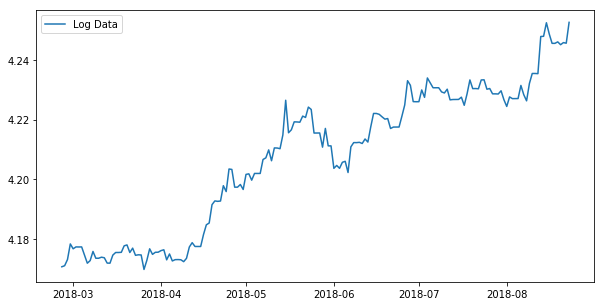

In [24]:
plt.rcParams["figure.figsize"] = fig_size
plt.plot(rate_data_log,label='Log Data')
plt.legend()
plt.show()

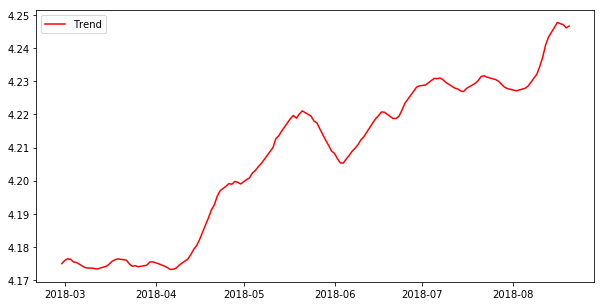

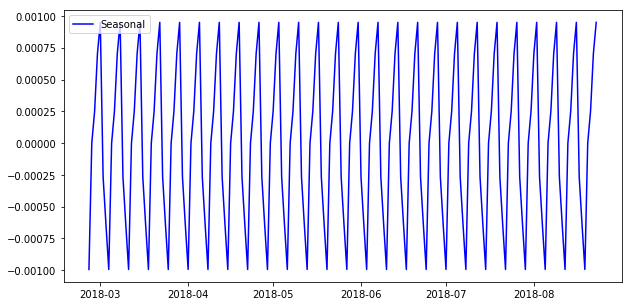

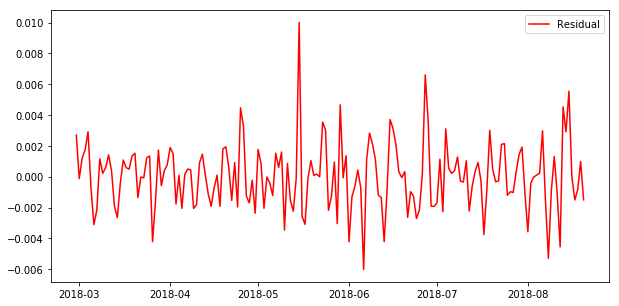

In [25]:
plt.plot(trend,color='red',label='Trend')
plt.legend()
plt.show()

plt.plot(seasonal,color='Blue',label='Seasonal')
plt.legend()
plt.show()

plt.plot(resid,color='red',label='Residual')
plt.legend()
plt.show()

In [26]:
resid.dropna(inplace=True)

df_test_resid = adfuller(resid, autolag='AIC')
result_resid = pd.Series(df_test_resid[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in df_test_resid[4].items():
    result_resid['Critical Value (%s)'%key] = value
print (result_resid)

Test Statistic                -8.885571e+00
p-value                        1.283020e-14
#Lags Used                     4.000000e+00
Number of Observations Used    1.690000e+02
Critical Value (1%)           -3.469648e+00
Critical Value (5%)           -2.878799e+00
Critical Value (10%)          -2.575971e+00
dtype: float64


In [27]:
compare=pd.DataFrame({'Test Statistic':[result_rmean_diff.iloc[0],result_log.iloc[0],result_ewma.iloc[0],result_logdiff.iloc[0],result_resid.iloc[0]],
                      'p-value':[result_rmean_diff.iloc[1],result_log.iloc[1],result_ewma.iloc[1],result_logdiff.iloc[1],result_resid.iloc[1]]})
Methods=['Data Rolling mean','Log Data Rolling Mean','Log EWMA','First Order Differencing','Seasonal Decomposition']
compare['Methods']=Methods
compare=compare.set_index('Methods')
compare

,Test Statistic,p-value
Methods,,
Data Rolling mean,-4.651251,1.038073e-04
Log Data Rolling Mean,-4.643230,1.074355e-04
Log EWMA,-2.831625,5.389638e-02
First Order Differencing,-15.382617,3.391714e-28
Seasonal Decomposition,-8.885571,1.283020e-14


Evidently, first order differencing gives the best smoothing to the data. It is very commonly used for making time series stationary because it seldom fails. However, we explored a few other smoothing techniques only to be sure.
Another advantage of first order differencing is that 'statsmodels.arima_models' has accounted for first order differencing.

### Determine time lags

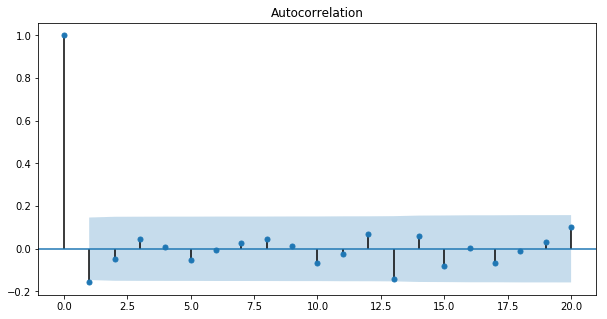

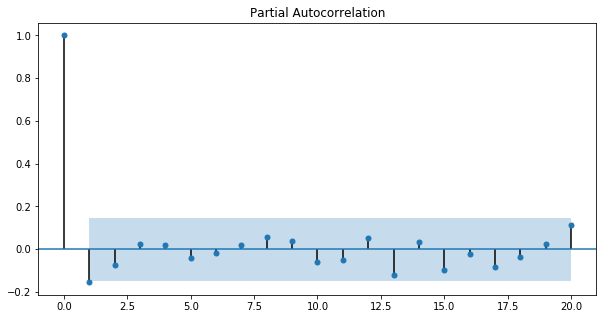

In [28]:
plot_acf(rate_log_diff,lags=20)
plt.show()

plot_pacf(rate_log_diff,lags=20)
plt.show()

## Forecast

#### 1 day ahead forecast

In [29]:
data1 = rate_data_log.values
train = list(data1[0:125])
train_ = list(data1[0:125])
test = list(data1[125:])
otest = list(data1[125:0])

train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(1,1,0))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(test[t]))

C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [30]:
model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
full_predictions=list(fit.forecast(34)[0])

Mean squared error: 0.043282


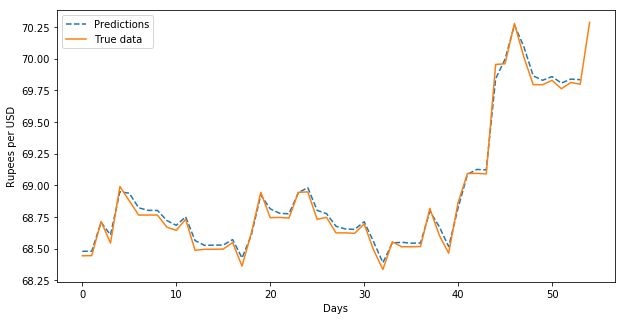

In [31]:
plt.plot(np.exp(predictions)[1:],'--',label='Predictions')
plt.plot(np.exp(test),label='True data')
#plt.plot(np.exp(full_predictions),label='Full prediction')
plt.ylabel('Rupees per USD')
plt.xlabel('Days')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(np.exp(test),np.exp(predictions))))

In [32]:
## Value of currency tomorrow will be:

#Tomorrow's value
train = list(data1)

train_list = [x for x in train]
predictions = []

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
forecast = float(fit.forecast()[0])

tomorrow_value = np.exp(forecast)

# Today's value

rate_data_log = rate_data_log[:-1]
data1 = rate_data_log.values
train = list(data1)

train_list = [x for x in train]
predictions = []

model = ARIMA(np.array(train),order=(1,1,0))
fit = model.fit()
forecast = float(fit.forecast()[0])
today_value = np.exp(forecast)

In [33]:
rate_data.tail()

,Rate
Day,
2018-08-19,69.8295
2018-08-20,69.7633
2018-08-21,69.8126
2018-08-22,69.7988
2018-08-23,70.2874


In [34]:
print ("Today's actual value is {0:3f} and model predicted {1:3f}.".format(rate_data.values[-1][0],today_value))
print ("Model predicts value will be {0:3f} tomorrow.".format(tomorrow_value))

Today's actual value is 70.287400 and model predicted 69.834939.
Model predicts value will be 70.246574 tomorrow.


#### Predicting for all 55 days in advance

C:\Users\kdabhadk\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Mean squared error: 3.060253


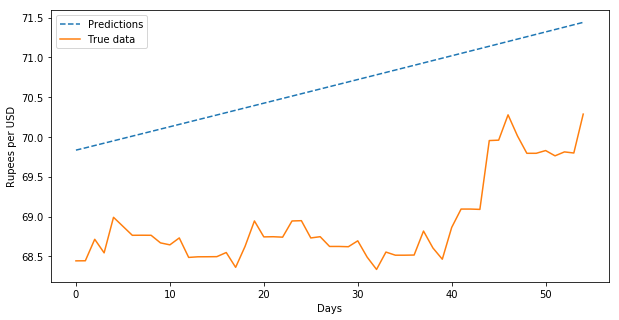

In [35]:
train_list = [x for x in train]
predictions = []

for t in range(len(test)):
    model = ARIMA(np.array(train),order=(1,1,0))
    fit = model.fit()
    forecast = float(fit.forecast()[0])
    predictions.append(forecast)
    train.append(float(forecast))

plt.plot(np.exp(predictions),'--',label='Predictions')
plt.plot(np.exp(test),label='True data')
#plt.plot(np.exp(full_predictions),label='Full prediction')
plt.ylabel('Rupees per USD')
plt.xlabel('Days')
plt.legend()
plt.plot()

print ('Mean squared error: {0:3f}'.format(MSE(np.exp(test),np.exp(predictions))))

Since, ARIMA is a linear model, forecasting using ARIMA for anywhere more than 1 day fails miserably.
The model continue the upward increasing trend.

Let's try to see how a simple LSTM Recurrent Neural Network (RNN) performs with this time series data.

### Recurrent Neural Network
Code template is adopted from https://github.com/neelabhpant/Deep-Learning-in-Python/blob/master/Time%20Series%20Prediction.ipynb <br>
The RNN is adjusted to suit as per requirement.

In [36]:
data1 = rate_data_log.values
train = list(data1[0:125])
test = list(data1[125:])

In [37]:
def gen_XY(t_list,size):
    X = np.zeros([1,size])
    Y = []
    temp_list=[]
    for i in range(len(t_list)-size):
        add_list = t_list[i:i+size]
        target = t_list[i+size]
        X = np.append(X,np.array([add_list]),axis=0)
        Y.append(target)
        
    X = np.delete(X,0,axis=0)
    Y = np.array(Y)
    
    return X,Y.T       

In [38]:
X_train,y_train = gen_XY(train,1)
X_test,y_test = gen_XY(test,1)

### 1 Hidden Layers with 1 neuron and relu activation function

In [39]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
124/124 [==============================] - 0s 878us/step - loss: 11.9651
Epoch 2/20
124/124 [==============================] - 0s 48us/step - loss: 11.6796
Epoch 3/20
124/124 [==============================] - 0s 48us/step - loss: 11.3980
Epoch 4/20
124/124 [==============================] - 0s 48us/step - loss: 11.1206
Epoch 5/20
124/124 [==============================] - 0s 40us/step - loss: 10.8478
Epoch 6/20
124/124 [==============================] - 0s 48us/step - loss: 10.5795
Epoch 7/20
124/124 [==============================] - 0s 49us/step - loss: 10.3163
Epoch 8/20
124/124 [==============================] - 0s 40us/step - loss: 10.0578
Epoch 9/20
124/124 [==============================] - 0s 41us/step - loss: 9.8044
Epoch 10/20
124/124 [==============================] - 0s 48us/step - loss: 9.5561
Epoch 11/20
124/124 [==============================] - 0s 65us/step - loss: 9.3125
Epoch 12/20
124/124 [==============================] - 0s 56us/step - loss: 9.0736
Epoc

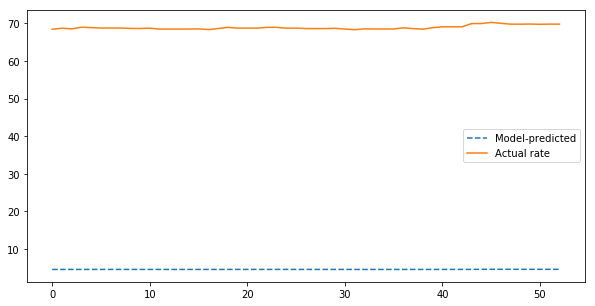

MSE: 4138.584711


In [40]:
y_pred  =  model.predict(X_test)
plt.plot(np.exp(y_pred),'--',label='Model-predicted')
plt.plot(np.exp(y_test),label='Actual rate')
plt.legend()
plt.show()
print('MSE: %f'%(MSE(np.exp(y_test), np.exp(y_pred))))

### 2 Hidden Layers with 50 neurons each and ReLU activation function

In [41]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
124/124 [==============================] - 0s 1ms/step - loss: 39.2726
Epoch 2/20
124/124 [==============================] - 0s 64us/step - loss: 11.6947
Epoch 3/20
124/124 [==============================] - 0s 56us/step - loss: 1.3381
Epoch 4/20
124/124 [==============================] - 0s 56us/step - loss: 0.2327
Epoch 5/20
124/124 [==============================] - 0s 65us/step - loss: 0.7506
Epoch 6/20
124/124 [==============================] - 0s 56us/step - loss: 0.4208
Epoch 7/20
124/124 [==============================] - 0s 65us/step - loss: 0.0525
Epoch 8/20
124/124 [==============================] - 0s 56us/step - loss: 0.0149
Epoch 9/20
124/124 [==============================] - 0s 64us/step - loss: 0.0343
Epoch 10/20
124/124 [==============================] - 0s 73us/step - loss: 0.0124
Epoch 11/20
124/124 [==============================] - 0s 89us/step - loss: 5.8156e-04
Epoch 12/20
124/124 [==============================] - 0s 129us/step - loss: 0.0021
Epoch 1

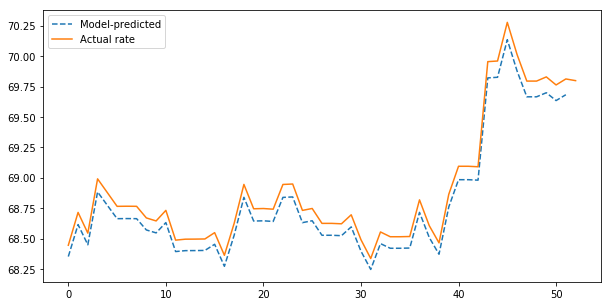

MSE: 0.057626


In [42]:
y_pred  =  model.predict(X_test)
plt.plot(np.exp(y_pred)[1:],'--',label='Model-predicted')
plt.plot(np.exp(y_test),label='Actual rate')
plt.legend()
plt.show()
print('MSE: %f'%(MSE(np.exp(y_test), np.exp(y_pred))))

### 4 Hidden Layers with 100 neurons each and ReLU activation function

In [43]:
K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

Epoch 1/20
124/124 [==============================] - 0s 2ms/step - loss: 15.3160
Epoch 2/20
124/124 [==============================] - 0s 89us/step - loss: 0.8558
Epoch 3/20
124/124 [==============================] - 0s 65us/step - loss: 0.7840
Epoch 4/20
124/124 [==============================] - 0s 73us/step - loss: 0.2611
Epoch 5/20
124/124 [==============================] - 0s 65us/step - loss: 0.0849
Epoch 6/20
124/124 [==============================] - 0s 73us/step - loss: 0.0753
Epoch 7/20
124/124 [==============================] - 0s 72us/step - loss: 0.0119
Epoch 8/20
124/124 [==============================] - 0s 72us/step - loss: 0.0117
Epoch 9/20
124/124 [==============================] - 0s 81us/step - loss: 0.0058
Epoch 10/20
124/124 [==============================] - 0s 81us/step - loss: 0.0012
Epoch 11/20
124/124 [==============================] - 0s 97us/step - loss: 8.9389e-04
Epoch 12/20
124/124 [==============================] - 0s 73us/step - loss: 5.3369e-04
Epoch

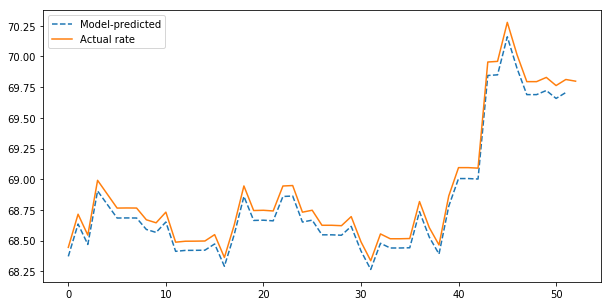

MSE: 0.052707


In [44]:
y_pred  =  model.predict(X_test)
plt.plot(np.exp(y_pred)[1:],'--',label='Model-predicted')
plt.plot(np.exp(y_test),label='Actual rate')
plt.legend()
plt.show()
print('MSE: %f'%(MSE(np.exp(y_test), np.exp(y_pred))))

In [45]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [46]:
X_tr_t.shape

(124, 1, 1)

In [47]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(10, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(10,input_shape=(1, X_train.shape[1]), activation='relu'))

model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
124/124 [==============================] - 1s 7ms/step - loss: 6.2460
Epoch 2/200
124/124 [==============================] - 0s 2ms/step - loss: 0.4828
Epoch 3/200
124/124 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 4/200
124/124 [==============================] - 0s 2ms/step - loss: 1.2927e-05
Epoch 5/200
124/124 [==============================] - 0s 2ms/step - loss: 1.3425e-05
Epoch 6/200
124/124 [==============================] - 0s 2ms/step - loss: 1.3497e-05
Epoch 7/200
124/124 [==============================] - 0s 2ms/step - loss: 1.3484e-05
Epoch 8/200
124/124 [==============================] - 0s 2ms/step - loss: 1.3441e-05
Epoch 9/200
124/124 [==============================] - 0s 2ms/step - loss: 1.3369e-05
Epoch 00009: early stopping


In [48]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)

print("The MSE on the Train set is:\t{:0.3f}".format(MSE(np.exp(y_train), np.exp(y_train_pred_lstm))))
print("The MSE on the Test set is:\t{:0.3f}".format(MSE(np.exp(y_test), np.exp(y_pred_test_lstm))))

The MSE on the Train set is:	0.071
The MSE on the Test set is:	0.052


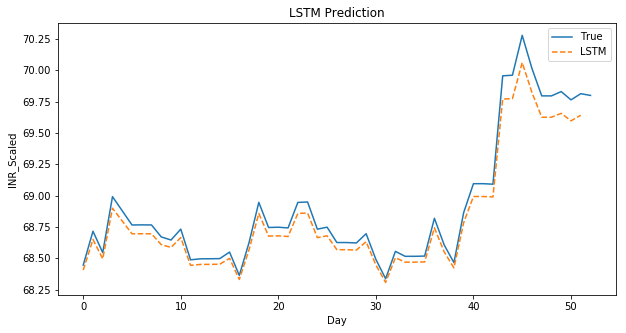

In [49]:
plt.plot(np.exp(y_test), label='True')
plt.plot(np.exp(y_pred_test_lstm)[1:],'--',label='LSTM')
plt.title("LSTM Prediction")
plt.xlabel('Day')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()